In [2]:
import urllib.request

url = "https://figshare.com/ndownloader/files/39181919"  # Replace with your direct download link
filename = "kf_2d_re1000_256_40seed.npy"     # Name to save the file as

urllib.request.urlretrieve(url, filename)
print(f"File downloaded and saved as {filename}")

File downloaded and saved as kf_2d_re1000_256_40seed.npy


In [3]:
url = "https://figshare.com/ndownloader/files/39214622"  # Replace with your direct download link
filename = "kmflow_sampled_data_irregnew.npz"     # Name to save the file as

urllib.request.urlretrieve(url, filename)
print(f"File downloaded and saved as {filename}")

File downloaded and saved as kmflow_sampled_data_irregnew.npz


In [17]:
import os 
import matplotlib.pyplot as plt 
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import numpy as np 
import torch
import torch.nn as nn
from torch import optim
import random


In [18]:
class CustomDataset(Dataset):
    def __init__(self, image_LR, image_HR, transform=None):
        self.image_LR = image_LR
        self.image_HR = image_HR
        self.LR_Data_ar = np.load(self.image_LR)
        self.HR_Data_ar = np.load(self.image_HR, allow_pickle=True)
        
        self.LR_Data = self.LR_Data_ar['u3232'].reshape(-1, 256, 256)
        self.HR_Data = self.HR_Data_ar.reshape(-1, 256, 256)
        
        assert len(self.LR_Data) == len(self.HR_Data), "LR and HR datasets must have same length"
        
        self.transform = transform
        
    def __len__(self):
        return len(self.LR_Data)
    
    def __getitem__(self, idx):
        LR_image = self.LR_Data[idx]
        HR_image = self.HR_Data[idx]
        
        if self.transform:
            LR_image = self.transform(LR_image).float()  # Convert to float32
            HR_image = self.transform(HR_image).float()  # Convert to float32
        else:
            LR_image = torch.from_numpy(LR_image).float().unsqueeze(0)
            HR_image = torch.from_numpy(HR_image).float().unsqueeze(0)
            
        return LR_image, HR_image

In [6]:
transform = transforms.Compose([
    transforms.ToTensor()
])

HR_Data = 'kf_2d_re1000_256_40seed.npy'
LR_Data = 'kmflow_sampled_data_irregnew.npz'

dataset = CustomDataset(LR_Data, HR_Data, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [7]:
for LR_batch, HR_batch in dataloader:
    print(f"LR batch shape: {LR_batch.shape}")  # Should be [32, 1, 256, 256]
    print(f"HR batch shape: {HR_batch.shape}")  # Should be [32, 1, 256, 256]
    break


LR batch shape: torch.Size([32, 1, 256, 256])
HR batch shape: torch.Size([32, 1, 256, 256])


In [8]:
class conv_block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(conv_block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

In [9]:
class conv_block2(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels, kernel_size):
        super(conv_block2, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


In [10]:
class dsm(nn.Module):
    def __init__(self, dim):
        super(dsm, self).__init__()
        self.conv1 = conv_block(dim, 32, 3)
        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv2 = conv_block(32 + dim, 32, 3)
        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv3 = conv_block(32 + dim, 32, 3)
        self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv4 = conv_block(32 + dim, 32, 3)

        self.pool1 = nn.MaxPool2d(kernel_size=8, stride=8)
        self.pool2 = nn.MaxPool2d(kernel_size=4, stride=4)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x1 = self.conv1(self.pool1(x))
        x1 = self.up1(x1)

        x2 = self.conv2(torch.cat([x1, self.pool2(x)], dim=1))
        x2 = self.up2(x2)

        x3 = self.conv3(torch.cat([x2, self.pool3(x)], dim=1))
        x3 = self.up3(x3)

        x4 = self.conv4(torch.cat([x3, x], dim=1))
        return x4

In [11]:
class msm(nn.Module):
    def __init__(self, dim):
        super(msm, self).__init__()
        self.conv1 = conv_block2(dim, 16, 8, 5)
        self.conv2 = conv_block2(dim, 16, 8, 9)
        self.conv3 = conv_block2(dim, 16, 8, 13)

        self.merge = nn.Sequential(
            nn.Conv2d(dim + 24, 8, kernel_size=7, padding=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(8, 3, kernel_size=5, padding=2),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x)
        x3 = self.conv3(x)
        x_merge = torch.cat([x, x1, x2, x3], dim=1)
        return self.merge(x_merge)

class full_model(nn.Module):
    def __init__(self, dim):
        super(full_model, self).__init__()
        self.dsm_net = dsm(dim)
        self.msm_net = msm(dim)
        self.final_conv = nn.Conv2d(32 + 3, dim, kernel_size=3, padding=1)

    def forward(self, x):
        x1 = self.dsm_net(x)
        x2 = self.msm_net(x)
        x_concat = torch.cat([x1, x2], dim=1)
        return self.final_conv(x_concat)


In [12]:
model = full_model(dim=1)

x = torch.randn(32, 1, 256, 256)
y = model(x)
print(y.shape)  


torch.Size([32, 1, 256, 256])


In [13]:
def train_model(model, train_loader, optimizer, criterion, device,scheduler ,num_epochs=10):
    history = {'train_loss': []}
    model.to(device)
    model = model.float()  
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        
        for LR_batch, HR_batch in train_loader:
            LR_batch = LR_batch.float().to(device) 
            HR_batch = HR_batch.float().to(device)  
            
            optimizer.zero_grad()
            outputs = model(LR_batch)
            loss = criterion(outputs, HR_batch)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * LR_batch.size(0)
        
        avg_train_loss = train_loss / len(train_loader.dataset)
        history['train_loss'].append(avg_train_loss)
        scheduler.step(avg_train_loss)
        
        print(f'Epoch: {epoch+1}/{num_epochs} Train Loss: {avg_train_loss:.4f}')
        
    return history

In [14]:
model = full_model(dim=1).float()  
optimizer = optim.Adam(model.parameters(), lr=5e-2)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
criterion = nn.MSELoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

history = train_model(
    model=model,
    train_loader=dataloader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    scheduler=scheduler,
    num_epochs=20
)

Epoch: 1/20 Train Loss: 13.1090
Epoch: 2/20 Train Loss: 3.1357
Epoch: 3/20 Train Loss: 2.9095
Epoch: 4/20 Train Loss: 2.8063
Epoch: 5/20 Train Loss: 2.7288
Epoch: 6/20 Train Loss: 2.6660
Epoch: 7/20 Train Loss: 2.6212
Epoch: 8/20 Train Loss: 2.5949
Epoch: 9/20 Train Loss: 2.5513
Epoch: 10/20 Train Loss: 2.5241
Epoch: 11/20 Train Loss: 2.5053
Epoch: 12/20 Train Loss: 2.4738
Epoch: 13/20 Train Loss: 2.4594
Epoch: 14/20 Train Loss: 2.4401
Epoch: 15/20 Train Loss: 2.4307
Epoch: 16/20 Train Loss: 2.4094
Epoch: 17/20 Train Loss: 2.3940
Epoch: 18/20 Train Loss: 2.3809
Epoch: 19/20 Train Loss: 2.3679
Epoch: 20/20 Train Loss: 2.3650


In [43]:
import random
import matplotlib.pyplot as plt
import torch
from torchvision import transforms

def output(dataloader, model, n=10):
    for LR_batch, HR_batch in dataloader:
        break

    batch_size = LR_batch.shape[0]
    sample_indices = random.sample(range(batch_size), min(n, batch_size))

    LR_samples = LR_batch[sample_indices].float().to(device)
    HR_samples = HR_batch[sample_indices].float().to(device)

    model.eval()
    with torch.no_grad():
        output_samples = model(LR_samples)

    all_imgs = torch.cat([LR_samples, output_samples, HR_samples], dim=0)
    vmin = all_imgs.min().item()
    vmax = all_imgs.max().item()

    # Plot LR
    fig, axs = plt.subplots(1, len(LR_samples), figsize=(15, 3))
    for i, ax in enumerate(axs):
        im = ax.imshow(LR_samples[i].squeeze().cpu().numpy(), cmap='jet', vmin=vmin, vmax=vmax)
        ax.set_title(f'LR Input {i}')
        ax.axis('off')
    fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.02, pad=0.02)

    # Plot Output
    fig, axs = plt.subplots(1, len(output_samples), figsize=(15, 3))
    for i, ax in enumerate(axs):
        im = ax.imshow(output_samples[i].squeeze().cpu().numpy(), cmap='jet', vmin=vmin, vmax=vmax)
        ax.set_title(f'HR Output {i}')
        ax.axis('off')
    fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.02, pad=0.02)

    # Plot HR
    fig, axs = plt.subplots(1, len(HR_samples), figsize=(15, 3))
    for i, ax in enumerate(axs):
        im = ax.imshow(HR_samples[i].squeeze().cpu().numpy(), cmap='jet', vmin=vmin, vmax=vmax)
        ax.set_title(f'Ground Truth {i}')
        ax.axis('off')
    fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.02, pad=0.02)
    plt.show()


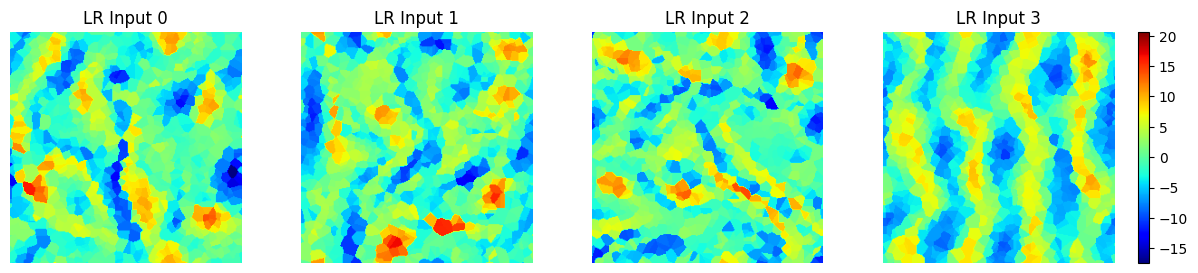

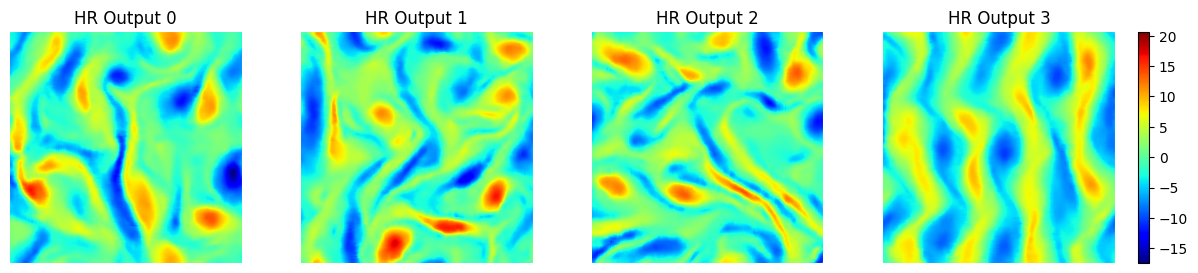

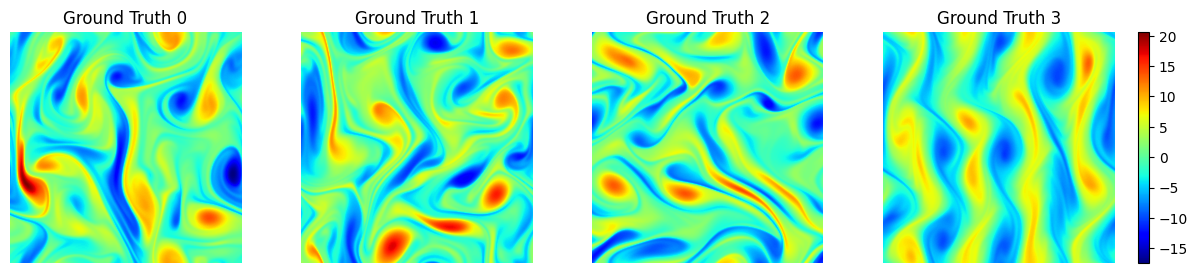

In [44]:
output(dataloader, model,n=4)

In [42]:
torch.save(model.state_dict(), "/kaggle/working/model_weights.pth")


In [24]:
os.path

<module 'posixpath' (frozen)>